In [267]:
## personal imports
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from functional.backtester import Backtester as b
from transformer.adhoc_transforms import Adhoc as adhocs
from transformer.risk_transforms import Risk as risks
from transformer.analysis_transforms import Analysis as anas

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [268]:
market = Market()

In [269]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [270]:
tyields = adhocs.tyields()
bench_returns = adhocs.spy_bench()

In [286]:
positions = 10
speculation_db = ADatabase(f"weeklies")
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()

In [287]:
trades = []
values = [True,False]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
parameters = []
strats = ["spec","rolling","window"]
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    parameter = {
                                "value":value
                                 ,"classification":classification
                                 ,"ceiling":ceiling
                                 ,"floor":floor
                                ,"strat":strat
                                }
                    parameters.append(parameter)

In [288]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [289]:
a

,value,classification,ceiling,floor,strat,pv,beta,rrr,sharpe
137,True,True,True,True,spec,2.040680,1.309458,1.301361,0.754725
137,True,True,True,False,spec,0.741662,1.618398,1.360098,-0.192004
137,True,True,False,True,spec,2.116893,1.371044,1.313070,0.776410
137,True,True,False,False,spec,0.909369,1.697354,1.375110,-0.084267
137,True,False,True,True,spec,2.146767,1.757219,1.386492,0.622784
137,True,False,True,False,spec,0.642983,2.164693,1.463963,-0.189134
137,True,False,False,True,spec,2.091097,1.776092,1.390080,0.584822
137,True,False,False,False,spec,0.704061,2.263237,1.482698,-0.153912
137,False,True,True,True,spec,1.477528,0.646280,1.175274,0.657808
137,False,True,True,False,spec,0.992809,0.751851,1.195346,-0.079259


In [290]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,pv,beta,rrr,sharpe
1,spec,True,False,True,True,2.146767,1.757219,1.386492,0.622784
2,window,True,False,False,True,2.378949,2.060824,1.444215,0.643698
0,rolling,True,False,False,True,2.730848,2.099182,1.451507,0.799573


In [302]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [308]:
ledger.sort_values("actual_returns",ascending=False).head(30)

,year,week,ticker,delta,delta_sign,actual_returns,position,GICS Sector
432,2020.0,23.0,AAL,0.567535,1.0,1.656863,3,Industrials
156,2020.0,23.0,UAL,0.645552,1.0,1.417753,1,Industrials
18,2020.0,23.0,OXY,0.705291,1.0,1.409492,0,Energy
846,2020.0,23.0,SPG,0.491881,1.0,1.396375,6,Real Estate
9,2020.0,13.0,MPC,2.255369,1.0,1.322857,0,Energy
1259,2020.0,23.0,APA,0.440560,1.0,1.313982,9,Energy
101,2022.0,11.0,EPAM,1.458222,1.0,1.308523,0,Information Technology
147,2020.0,13.0,VLO,1.580331,1.0,1.299856,1,Energy
984,2020.0,23.0,DAL,0.451949,1.0,1.293449,7,Industrials
294,2020.0,23.0,NCLH,0.611411,1.0,1.289822,2,Consumer Discretionary


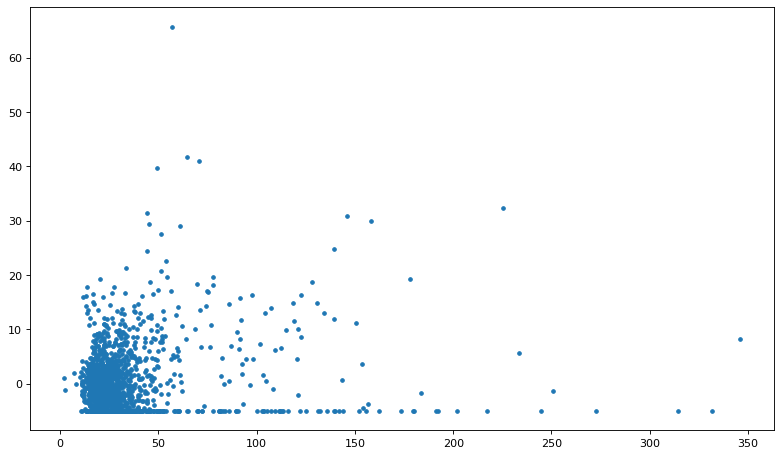

In [293]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger["delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [294]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()

In [295]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') + timedelta(days=4) for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 1/positions for column in counted_columns]) for row in cumulative.iterrows()]
bench = adhocs.spy_bench()
bench = bench.fillna(method="bfill")
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative = cumulative.fillna(method="bfill")

In [296]:
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,0.979519,0.963718,0.980311,0.959985,0.976995,1.011494,0.981703,0.974663,0.988816,0.979665,2020-W2,2020-01-10,0.979687,322.41,1.000000
1,0.930543,0.957233,1.003864,0.941411,0.969093,0.967953,0.942248,0.941564,0.976324,0.985404,2020-W3,2020-01-17,0.961564,325.71,1.010235
2,0.995550,0.958525,1.086920,0.935985,0.928248,0.989406,0.976688,0.962591,0.994432,1.010777,2020-W5,2020-01-31,0.983912,328.77,1.019726
3,1.013617,0.991075,1.098327,0.889185,0.960240,1.015692,1.001117,0.918480,0.999154,1.027638,2020-W6,2020-02-07,0.991452,321.73,0.997891
4,1.011964,0.955340,1.095663,0.864229,0.967712,1.026018,1.111310,0.919557,1.000260,0.976256,2020-W7,2020-02-14,0.992831,332.20,1.030365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,5.923533,1.898540,1.726597,3.325270,3.098492,2.833888,0.756067,1.684430,1.473606,4.104054,2022-W47,2022-11-25,2.682448,396.03,1.228343
134,5.925887,2.102558,1.739223,3.751486,3.398109,2.886322,0.782001,1.685010,1.445722,4.486915,2022-W48,2022-12-02,2.820323,402.33,1.247883
135,6.024652,2.112897,1.845243,3.751059,3.524399,2.939868,0.742901,1.690347,1.556822,4.580819,2022-W49,2022-12-09,2.876901,406.91,1.262089
136,5.723419,2.007252,1.757529,3.563506,3.348179,2.792875,0.705756,1.605829,1.568677,4.553369,2022-W50,2022-12-16,2.762639,393.28,1.219813


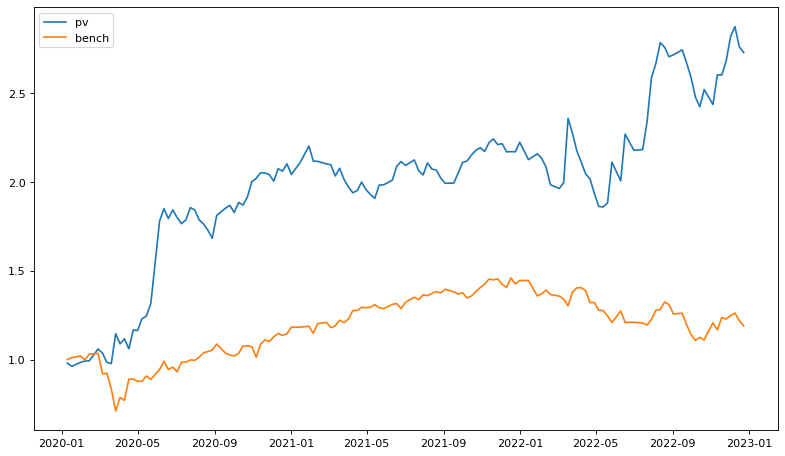

In [297]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

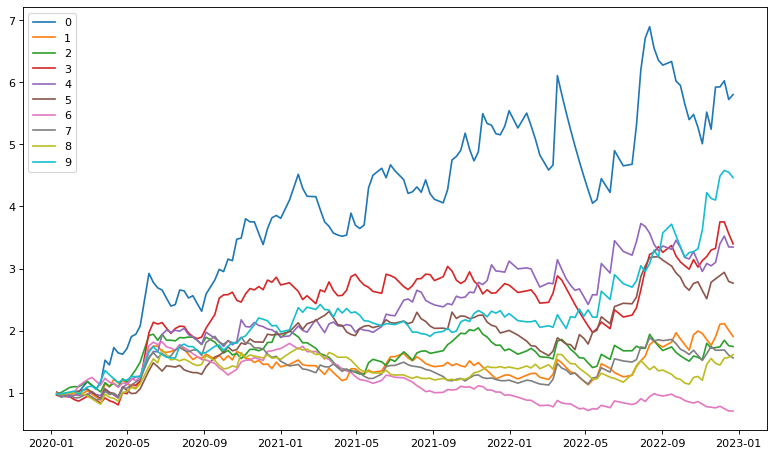

In [298]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()


In [299]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,year,week,delta,actual_returns,position
GICS Sector,,,,,
Consumer Discretionary,2020.878882,29.276398,0.422656,1.005055,3.900621
Energy,2020.789474,23.350877,0.414152,1.022342,4.730994
Industrials,2020.736000,27.520000,0.410543,1.006664,4.952000
Communication Services,2021.431655,27.107914,0.360257,1.004047,3.762590
Real Estate,2020.928571,24.321429,0.325154,1.022509,6.571429
Financials,2020.690909,24.072727,0.315554,1.013387,5.490909
Information Technology,2021.030075,27.545113,0.294166,1.003669,4.627820
Health Care,2021.118750,31.025000,0.280225,1.008863,4.475000
Materials,2021.013333,30.160000,0.276052,1.003153,4.920000


In [300]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.020000e+03,2.000000e+00,1.000000,0.974663,1.000000,1.000000,1.000000,0.977299,1.000000,0.975380,1.011494,1.000000,1.000000
1,4.080400e+06,6.000000e+00,1.000000,0.957933,1.000000,1.000000,0.987367,1.000779,1.000000,0.949179,1.011494,1.000000,1.000000
2,8.242408e+09,3.000000e+01,1.000000,0.957933,1.000000,0.957852,0.987367,1.060469,1.022163,0.970072,1.011494,1.000000,1.000000
3,1.664966e+13,1.800000e+02,1.033959,0.914035,1.000000,0.982636,0.987367,1.088643,1.032890,0.921569,1.016297,1.000000,1.016681
4,3.363232e+16,1.260000e+03,1.033959,0.904828,1.000000,0.983725,0.987367,1.208471,1.032890,0.901125,1.024205,1.000000,1.016681
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,inf,5.941791e+179,1.193617,0.986340,1.039060,1.958930,1.317399,2.158912,0.869085,1.509091,1.250363,1.710266,1.246769
134,inf,2.852060e+181,1.274477,0.986133,1.039060,1.958930,1.317399,2.285962,0.869430,1.655016,1.250363,1.710266,1.246769
135,inf,1.397509e+183,1.295719,0.991352,1.039060,2.109469,1.317399,2.304235,0.869430,1.701122,1.250363,1.710266,1.246769
136,inf,6.987546e+184,1.251004,0.960823,1.039060,2.109469,1.251529,2.189023,0.825958,1.701122,1.250363,1.710266,1.184431
